Note: Vscode doesn't seems to recognize the .venv in Mac. You will have to paste the path to ~/.venv/bin/python in the `Python: Select interpreter` command.

In [13]:
import os
from pathlib import Path, PosixPath
from dotenv import load_dotenv
from PIL import Image
from random import shuffle
from collections import Counter
import json
from tqdm.notebook import tqdm
from rich import print

In [2]:
ENV_Path = Path("../MultiLabel_N24/envs/n24.env")
load_dotenv(str(ENV_Path))

True

In [3]:
data_dir = Path(os.environ.get("DATASET_ROOT"))
os.listdir(data_dir)

['.DS_Store', 'imgs', 'news']

### Examining imgs within the dataset!

Total number of images: 61236
Image shape: 1050x549


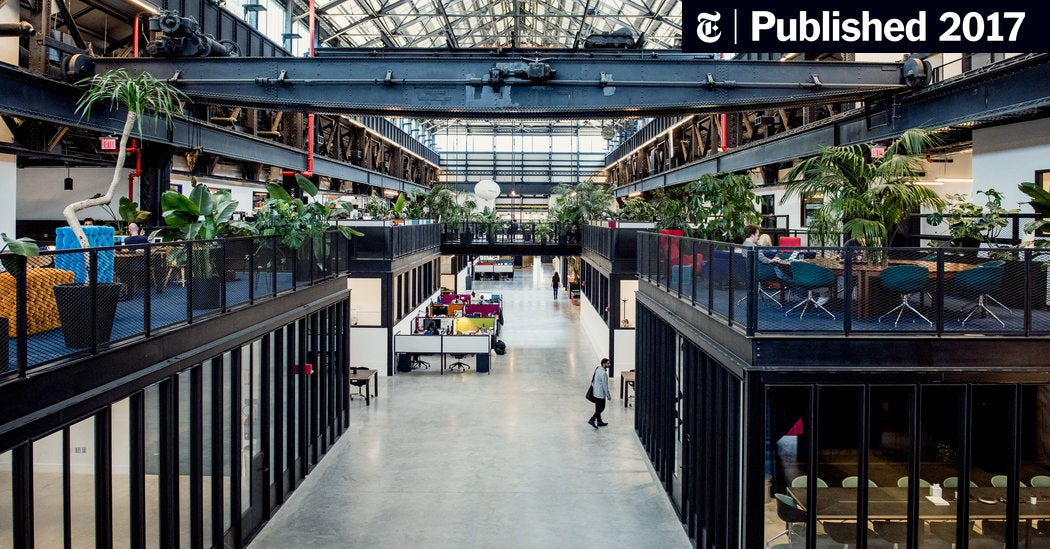

In [4]:
img_dir = data_dir / "imgs"
img_fname = os.listdir(img_dir)[0]
print(f"Total number of images: {len(os.listdir(img_dir))}")
im = Image.open(img_dir / img_fname)
width, height = im.size
print(f"Image shape: {width}x{height}")
im

In [5]:
## Let's randomly query 5 images and see how the shapes change
img_fnames = os.listdir(img_dir)
shuffle(img_fnames)
shape_tracker, failed = [], []
for fname in img_fnames:
    try:
        im = Image.open(img_dir / fname)
        shape_tracker.append(im.size)
        del im
    except Exception as e:
        failed.append(fname)

In [6]:
(37290 + 15504) / len(os.listdir(img_dir))

0.8621399176954733

In [7]:
c = Counter(shape_tracker)
c.most_common(15)

[((1050, 550), 37290),
 ((1050, 549), 15504),
 ((600, 400), 1226),
 ((600, 330), 602),
 ((600, 315), 509),
 ((600, 350), 309),
 ((600, 370), 262),
 ((600, 360), 147),
 ((600, 399), 144),
 ((600, 338), 98),
 ((600, 900), 71),
 ((600, 401), 63),
 ((600, 340), 59),
 ((1024, 536), 58),
 ((603, 316), 57)]

#### Takeways:
1. Images have a varied distribution of resolution hence it may be wise to resize/pad to either the median resolution or to the model's resolution.
2. More than 85% of the dataset has image resolution (1050x549).

### Examing the text description
1. Based on the paper[!https://aclanthology.org/2022.lrec-1.729.pdf], we do know that we shall have a headline, catpion, abstract and body.

In [8]:
doc_dir = data_dir / "news"
with open(doc_dir / "nytimes_train.json", "r") as fp:
    news_list = json.load(fp)

In [9]:
key_list = []
for news_dict in tqdm(news_list):
    for key in news_dict.keys():
        if key not in key_list:
            key_list.append(key)

  0%|          | 0/48988 [00:00<?, ?it/s]

In [14]:
print(news_dict["article"])

The visionary landscapist Joseph Elmer Yoakum (1888-1972) has been categorized as an outsider, self-taught or folk 
artist. Whichever: His place in the expanding canon of 20th-century American art is assured, both for his 
achievement and influence. The latest evidence of Yoakum's originality is this enthralling exhibition, among the 
largest ever devoted to his work. It features nearly 70 of the artist's delirious vistas of undulant hills, 
mountains and rock formations, variously striated, patterned and creviced, rendered in pale browns and pastels of 
colored pencil burnished to resemble watercolor. Defined by double outlines, Yoakum's geological elements have a 
curious autonomy: They heave, lean and push against one another, but they also evoke soft creased flesh, voluptuous
but slightly abstracted. Sudden breaks in the terrain offer views of tiny trees, distorting space and scale and 
intensifying the sexual undercurrent.

A magnetic ambiguity prevails. In "Mt Horseback on Rockey Knob Range Near Chillicothe, Ohio" (1969), tan flowing 
forms divide the scene like irregular columns. They could be landslides, or an alternate universe alive with 
writhing snakes and worms.

Yoakum concocted his fantastical topographies in a storefront on the South Side of Chicago during the last decade 
of his life, after years spent traveling the world as an itinerant worker. Once discovered, his art exerted an 
essential influence on Chicago Imagists like Jim Nutt, Roger Brown and Christina Ramberg. Beginning in 1968, he had
several exhibitions in Chicago; one at the Whitney Museum in New York opened in late 1972, just weeks before he 
died on Christmas Day. ROBERTA SMITH

In [10]:
key_list

['section',
 'headline',
 'article_url',
 'article',
 'abstract',
 'article_id',
 'image',
 'caption',
 'image_id']

#### Takeaways:
1. target column name: `section`
2. text columns: `headline`, `article`, `abstract`, `caption`
3. The `body` section in paper is `article` in this dataset. 
4. Each dictionary file is associated with an image-id.

### Final Take-aways:
1. Main target: Predict the news_category using a combination of text+img. 
    * Perform ablation study to evaluate the performance using different domains.
    * Create attention/GradCAM on just the image to visualize what the model is interested in.
2. Generate news-headline/captions based on the image + text - Multi-modal caption generator.
3. News/Image retrieval task for News Recommendation.